# Topic Modeling
* This notebook illustrates performing topic modeling using NMF on the list of offenses. 


In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from ipywidgets import widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import json
import copy

# Preprocessing

In [2]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv("docket-parsed.csv", index_col=0)
courtdf = pd.read_csv("court-parsed.csv", index_col=0)
df = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
df.reset_index(inplace=True)
df.drop(columns=['docket_no'], inplace=True)
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [3]:
# convert string to datetime
df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = df["prelim_hearing_dt"].apply(
    lambda x: str(x).split(' ')[0] if pd.notnull(x) else x) # This is here because of a parsing issue
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# age column
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
# note that there is also an "attorney_type" column, with "Public", "Private", and "Court Appointed" options
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df['offense_type'] = df['offense_type'].apply(lambda x: ast.literal_eval(x))
df['statute'] = df['statute'].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# column indicating whether zipcode is in Philadelphia
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

# outstanding bail column
df['bail_outstanding'] = df['bail_amount'] - df['bail_paid']

In [4]:
# remove arrests that occurred between 5/31 - 6/3 (BLM movement)
df = df[(df['arrest_dt'] < np.datetime64('2020-05-31')) | (df['arrest_dt'] > np.datetime64('2020-06-03'))]
df.reset_index(drop = True, inplace = True)

In [22]:
# set core magistrates to analyze
core_magistrates = ['Bernard, Francis X.', 'Rigmaiden-DeLeon, Marilyn', "O'Brien, James", 'Stack, Patrick', 'E-Filing Judge']

In [5]:
# remove offenses with super long length
df['max_offense_length'] = df['offenses'].apply(lambda x: max([len(item) for item in x]))

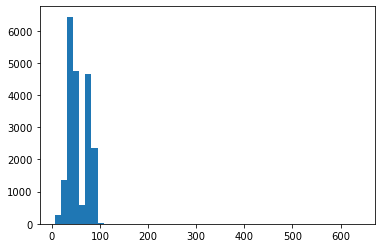

In [6]:
plt.hist(df['max_offense_length'], bins = 50)
plt.show()

In [7]:
# take a look at cases with long offenses
df_long = df[df['max_offense_length'] > 200]

In [12]:
df_long

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,prelim_hearing_dt,prelim_hearing_time,sex,race,age,public_defender,zipcode_clean,philly_zipcode,bail_outstanding,max_offense_length
9529,Mark S. Keenheel,Private,"[Rape Forcible Compulsion, Unlawful Contact Wi...",2020-06-10,"[18 § 3121 §§ A1, 18 § 6318 §§ A1, 18 § 2902 §...","[sexual offenses, minors, kidnapping, sexual o...",E-Filing Judge,100000.0,0.0,2020-06-16,...,2020-06-16,2020-12-08 09:11:00,Male,Black,24.0,0,NaN,0,100000.0,234
10018,Richard John Fuschino Jr.,Private,[Photograph/Film/Depict on Computer Sex Act - ...,2020-02-05,"[18 § 6312 §§ B1, 18 § 6312 §§ B1, 18 § 6312 §...","[minors, minors, minors, minors, minors, minor...",E-Filing Judge,250000.0,25000.0,2020-07-09,...,2020-06-26,2020-12-08 11:59:00,Male,Asian/Pacific Islander,35.0,0,19148,1,225000.0,639


In [10]:
df.at[9529, 'offenses']

['Rape Forcible Compulsion',
 'Unlawful Contact With Minor - Sexual Offenses',
 'Unlawful Restraint/ Serious Bodily Injury',
 'Sexual Assault',
 'Corruption Of Minors - Defendant Age 18 or Above',
 'Endangering Welfare of Children - Parent/Guardian/Other Commits Offense',
 'Indecent Assault Forcible Compulsion',
 'Statutory Sexual Assault: 11 Years Older Rape of Child IDSI Forcible Compulsion',
 'Rape of Child IDSI Forcible Compulsion Incarceration/Diversionary Period Disposition Date Offense Disposition Sentence Date 06/16/2020 Proceed to Court Proceed to Court Proceed to Court Proceed to Court Proceed to Court F1 F1 F2 F2 F3',
 'IDSI Forcible Compulsion']

In [11]:
# remove offenses with long length
df['cleaned_offenses'] = df['offenses'].apply(lambda x: [item for item in x if len(item) < 200])

# manually adjust for item 10678
df.at[10018, 'cleaned_offenses'] = ['Photograph/Film/Depict on Computer Sex Act - Knowingly or Permitting Child',
                                    'Child Pornography']

# Prepare corpus

In [13]:
def cleanText(text):
    
    # remove punctuations
    text = re.sub('\,','', text)
    text = re.sub('\.','', text)
    text = re.sub('\:','', text)
    text = re.sub('\-', ' ',text)
    
    return text

In [14]:
# prepare text (offenses)
df['corpus'] = df['cleaned_offenses'].apply(lambda x: ' '.join(x))
df['corpus'] = df['corpus'].apply(cleanText)
corpus = df['corpus'].tolist()

# remove stop words
stopwords = ['for','a','of','the','and','to','in', 'or']

# corpus format: list of list
# lowercase
corpus = [[word for word in text.lower().split() if word not in stopwords] for text in corpus]

# create dictionary of worrds
dictionary = Dictionary(corpus)

# prepare corpus
total_corpus = [dictionary.doc2bow(text) for text in corpus]

# Choose topic numbers

In [15]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(2,30))
scores = {}

for k in topic_numbers:
    # train NMF model
    nmf = Nmf(total_corpus, id2word = dictionary, kappa = 0.1, passes = 20, num_topics = k, normalize = True)
    
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=corpus, coherence='u_mass')
    coherence = cm.get_coherence() 
    scores[k] = coherence

In [ ]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

The U-mass coherence score plateaus around 8. So appropriate topic number is around 10-20

In [ ]:
# train NMF model
n_topics = 11
nmf = Nmf(total_corpus, id2word = dictionary, kappa = 0.1, passes =20, num_topics = n_topics, normalize = True)

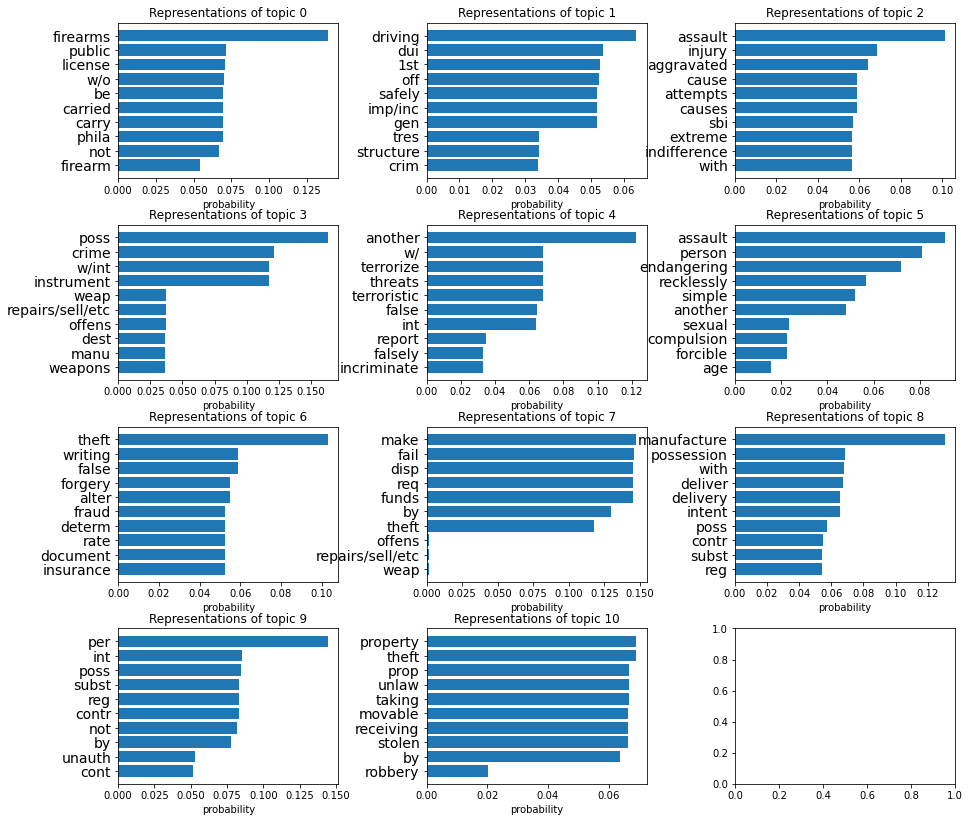

In [18]:
# Visualize topic representations 
n_topics = 11
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 14))

for i in range(n_topics):
    row = i // 3
    col = i % 3
    
    topic_rep = nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob)
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

In [16]:
# save NMF model
#nmf.save('offenses_nmf')

# to load
nmf = Nmf.load('offenses_nmf')

In [19]:
# for each offense, assign topic number 
topic_numbers = []

for case in total_corpus:
    topics = nmf[case]
    topic_num = [item[0] for item in topics]
    topic_prob = [item[1] for item in topics]
    topic_numbers.append(topic_num[topic_prob.index(max(topic_prob))])
    
# create column of offense type
df['topic_numbers'] = topic_numbers

<b> Q: Are there correlations between offense type and magistrate? </b>

In [20]:
df_magistrate_offense = pd.crosstab(index = df['bail_set_by'], columns =df['topic_numbers'])
df_magistrate_offense['Total'] = df_magistrate_offense.sum(axis = 1)

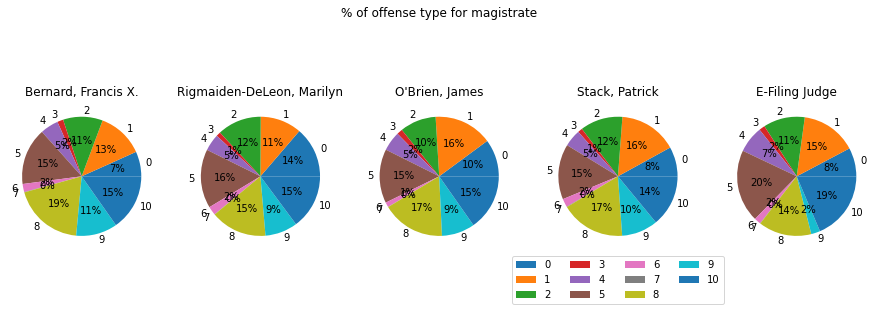

In [23]:
# visualize
n_topics = 11
topic_nums = list(range(n_topics))

fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of offense type for magistrate')
for idx, name in enumerate(core_magistrates):

    ax[idx].pie(df_magistrate_offense.loc[name, topic_nums], labels = topic_nums, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

From what we see above, each magistrate seems to handle similar proportions of offense types

In [24]:
# test
df_chi = df_magistrate_offense.drop(columns = ['Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.3840174325752478e-31


From the above, it's kind of hard to tell why we get a significant result. We may need more specific tests


In [25]:
def chisquare_by_topic(df_magistrate_offense, topic_num, magistrates):
    df_chi = df_magistrate_offense.loc[magistrates]
    df_chi['not'] = df_chi['Total'] - df_chi[topic_num]
    # chi-squared test"
    chi2, p, dof, ex = chi2_contingency(df_chi[[topic_num, 'not']])
    return p

In [27]:
# chi-square test for each topic
for i in range(n_topics):
    p = chisquare_by_topic(df_magistrate_offense, i, core_magistrates)
    print('p-value of chi-square test for topic %d : %.4f' %(i,p))
    

p-value of chi-square test for topic 0 : 0.0000
p-value of chi-square test for topic 1 : 0.0000
p-value of chi-square test for topic 2 : 0.1175
p-value of chi-square test for topic 3 : 0.6552
p-value of chi-square test for topic 4 : 0.0091
p-value of chi-square test for topic 5 : 0.0009
p-value of chi-square test for topic 6 : 0.0183
p-value of chi-square test for topic 7 : 0.8798
p-value of chi-square test for topic 8 : 0.0006
p-value of chi-square test for topic 9 : 0.0000
p-value of chi-square test for topic 10 : 0.0070


* The above shows that some magistrates are more likely to handle cases involving particular offenses.
* When we analyze magistrate's effect on bail type and bail amount, we should do a matched analysis

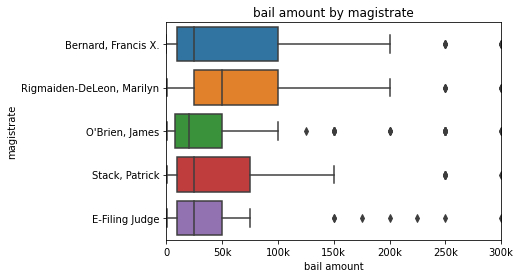

In [29]:
# for offense of type 8 (drug possession and delivery), do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['topic_numbers'] == 8)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

It does look like given the same offense type (drug possession and delivery) Bernard and Rigmaiden-DeLeon tend to set higher bails than the others